# Exploring generations

In [25]:
# improts
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import re
from pathlib import Path
from glob import glob
import pickle
import shutil
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
import py3Dmol

from ipywidgets import interact,fixed,IntSlider

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


#IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 500,500

templates = Path('../templates/')
generation_path = Path('~').expanduser()/'generation_correct_scoring'


### First test generation

In [26]:
generation_path

PosixPath('/home/magstr/generation_correct_scoring')

In [27]:
def draw_generation(
    mols,
    width=800,
    height=600,
    Hs=False,
    confId=-1,
    multipleConfs=False,
    atomlabel=False,
):
    try:
        p = py3Dmol.view(width=width, height=height)
        if type(mols) is not list:
            mols = [mols]
        for mol in mols:
            if multipleConfs:
                for conf in mol.GetConformers():
                    mb = Chem.MolToMolBlock(mol, confId=conf.GetId())
                    p.addModel(mb, "sdf")
            else:
                if type(mol) is str:
                    if os.path.splitext(mol)[-1] == ".xyz":
                        xyz_f = open(mol)
                        line = xyz_f.read()
                        xyz_f.close()
                        p.addModel(line, "xyz")
                else:
                    mb = Chem.MolToMolBlock(mol, confId=confId)
                    p.addModel(mb, "sdf")
        p.setStyle({"stick": {"radius": 0.2}})
        if atomlabel:
            p.addPropertyLabels("index")  # ,{'elem':'H'}
        p.zoomTo()
        p.update()
        # p.show()
    except Exception as e:
        print(e)
        print("py3Dmol, RDKit, and IPython are required for this feature.")

In [28]:
templates = Path('../templates/')
generation_path = Path('~').expanduser()/"Documents/generation_data/generation_charge_spin_20gen"

In [29]:
files = generation_path.rglob('*xtbopt.xyz')
paths = sorted(files)

In [30]:
Mo_NH3_paths = [path for path in paths if 'Mo' in str(path.parents[1])] 
catalyst_paths = [path for path in paths if 'catalyst' in str(path.parents[1])] 

In [31]:
confs = catalyst_paths

def conf_viewer(idx):
    mol = confs[idx]
    gen = confs[idx].parts[-3].split('_')[0][1:]
    print(f'Generation : {gen}')
    return draw_generation(str(confs[idx]))

interact(conf_viewer, idx=IntSlider(min=0,max=len(confs)-1, step=1))
# 216, 
# 38 shows something along the lines of HIPT. 
# 54 is a larger one
# 260 water
# 266 weird one

# 287 amines

interactive(children=(IntSlider(value=0, description='idx', max=297), Output()), _dom_classes=('widget-interac…

<function __main__.conf_viewer(idx)>

In [8]:
confs = Mo_NH3_paths
interact(conf_viewer, idx=IntSlider(min=0,max=len(confs)-1, step=1))
#12


interactive(children=(IntSlider(value=0, description='idx', max=234), Output()), _dom_classes=('widget-interac…

<function __main__.conf_viewer(idx)>

## Final generation analysis

### What where the molecules in final generatin? 

In [9]:
[path for path in paths if '/020_' in str(path.parents[1])] 

[PosixPath('/home/magstr/Documents/generation_data/generation_charge_spin_20gen/020_000_Mo_NH3/conf000/xtbopt.xyz'),
 PosixPath('/home/magstr/Documents/generation_data/generation_charge_spin_20gen/020_000_catalyst/conf000/xtbopt.xyz'),
 PosixPath('/home/magstr/Documents/generation_data/generation_charge_spin_20gen/020_003_Mo_NH3/conf000/xtbopt.xyz'),
 PosixPath('/home/magstr/Documents/generation_data/generation_charge_spin_20gen/020_003_catalyst/conf000/xtbopt.xyz'),
 PosixPath('/home/magstr/Documents/generation_data/generation_charge_spin_20gen/020_005_catalyst/conf000/xtbopt.xyz'),
 PosixPath('/home/magstr/Documents/generation_data/generation_charge_spin_20gen/020_006_Mo_NH3/conf000/xtbopt.xyz'),
 PosixPath('/home/magstr/Documents/generation_data/generation_charge_spin_20gen/020_006_catalyst/conf000/xtbopt.xyz'),
 PosixPath('/home/magstr/Documents/generation_data/generation_charge_spin_20gen/020_007_Mo_NH3/conf000/xtbopt.xyz'),
 PosixPath('/home/magstr/Documents/generation_data/gener

In [10]:
final_gen_mo_nh3 = [path for path in paths if '/020_' in str(path.parents[1])] 

In [11]:
confs = final_gen_mo_nh3
interact(conf_viewer, idx=IntSlider(min=0,max=len(confs)-1, step=1))

interactive(children=(IntSlider(value=0, description='idx', max=22), Output()), _dom_classes=('widget-interact…

<function __main__.conf_viewer(idx)>

# Flexible amines 3 gen

In [32]:
templates = Path('../templates/')
generation_path = Path('~').expanduser()/"Documents/generation_data/generation_amine_rework_20"

In [33]:
files = generation_path.rglob('*xtbopt.xyz')
paths = sorted(files)

In [34]:
Mo_NH3_paths = [path for path in paths if 'Mo' in str(path.parents[1])] 
catalyst_paths = [path for path in paths if 'catalyst' in str(path.parents[1])] 

In [37]:
confs = catalyst_paths

def conf_viewer(idx):
    mol = confs[idx]
    gen = confs[idx].parts[-3].split('_')[0][1:]
    print(f'Generation : {gen}')
    return draw_generation(str(confs[idx]))

interact(conf_viewer, idx=IntSlider(min=0,max=len(confs)-1, step=1))
# 216, 
# 38 shows something along the lines of HIPT. 
# 54 is a larger one
# 260 water
# 266 weird one

interactive(children=(IntSlider(value=0, description='idx', max=298), Output()), _dom_classes=('widget-interac…

<function __main__.conf_viewer(idx)>

In [38]:
confs = Mo_NH3_paths
interact(conf_viewer, idx=IntSlider(min=0,max=len(confs)-1, step=1))
#12


interactive(children=(IntSlider(value=0, description='idx', max=223), Output()), _dom_classes=('widget-interac…

<function __main__.conf_viewer(idx)>

## Final generation analysis

### What where the molecules in final generation? 

In [39]:
[path for path in paths if '/002_' in str(path.parents[1])] 

[PosixPath('/home/magstr/Documents/generation_data/generation_amine_rework_20/002_000_Mo_NH3/conf000/xtbopt.xyz'),
 PosixPath('/home/magstr/Documents/generation_data/generation_amine_rework_20/002_000_catalyst/conf000/xtbopt.xyz'),
 PosixPath('/home/magstr/Documents/generation_data/generation_amine_rework_20/002_001_Mo_NH3/conf000/xtbopt.xyz'),
 PosixPath('/home/magstr/Documents/generation_data/generation_amine_rework_20/002_001_catalyst/conf000/xtbopt.xyz'),
 PosixPath('/home/magstr/Documents/generation_data/generation_amine_rework_20/002_002_catalyst/conf000/xtbopt.xyz'),
 PosixPath('/home/magstr/Documents/generation_data/generation_amine_rework_20/002_003_Mo_NH3/conf000/xtbopt.xyz'),
 PosixPath('/home/magstr/Documents/generation_data/generation_amine_rework_20/002_003_catalyst/conf000/xtbopt.xyz'),
 PosixPath('/home/magstr/Documents/generation_data/generation_amine_rework_20/002_004_Mo_NH3/conf000/xtbopt.xyz'),
 PosixPath('/home/magstr/Documents/generation_data/generation_amine_rewo

In [40]:
final_gen_mo_nh3 = [path for path in paths if '/002_' in str(path.parents[1])] 

In [41]:
confs = final_gen_mo_nh3
interact(conf_viewer, idx=IntSlider(min=0,max=len(confs)-1, step=1))

interactive(children=(IntSlider(value=0, description='idx', max=26), Output()), _dom_classes=('widget-interact…

<function __main__.conf_viewer(idx)>

### The best ones from final generation

In [42]:
generation_path

PosixPath('/home/magstr/Documents/generation_data/generation_amine_rework_20')

In [44]:
with open(generation_path/'GA20.pkl', "rb") as f:
    gen20 = pickle.load(f)

In [45]:
#gen20.gen2pd()

In [46]:
mols = []
idx = []
for elem in gen20.survivors.molecules:
    mols.append(Chem.MolFromSmiles(elem.smiles))
    idx.append(elem.idx[1])

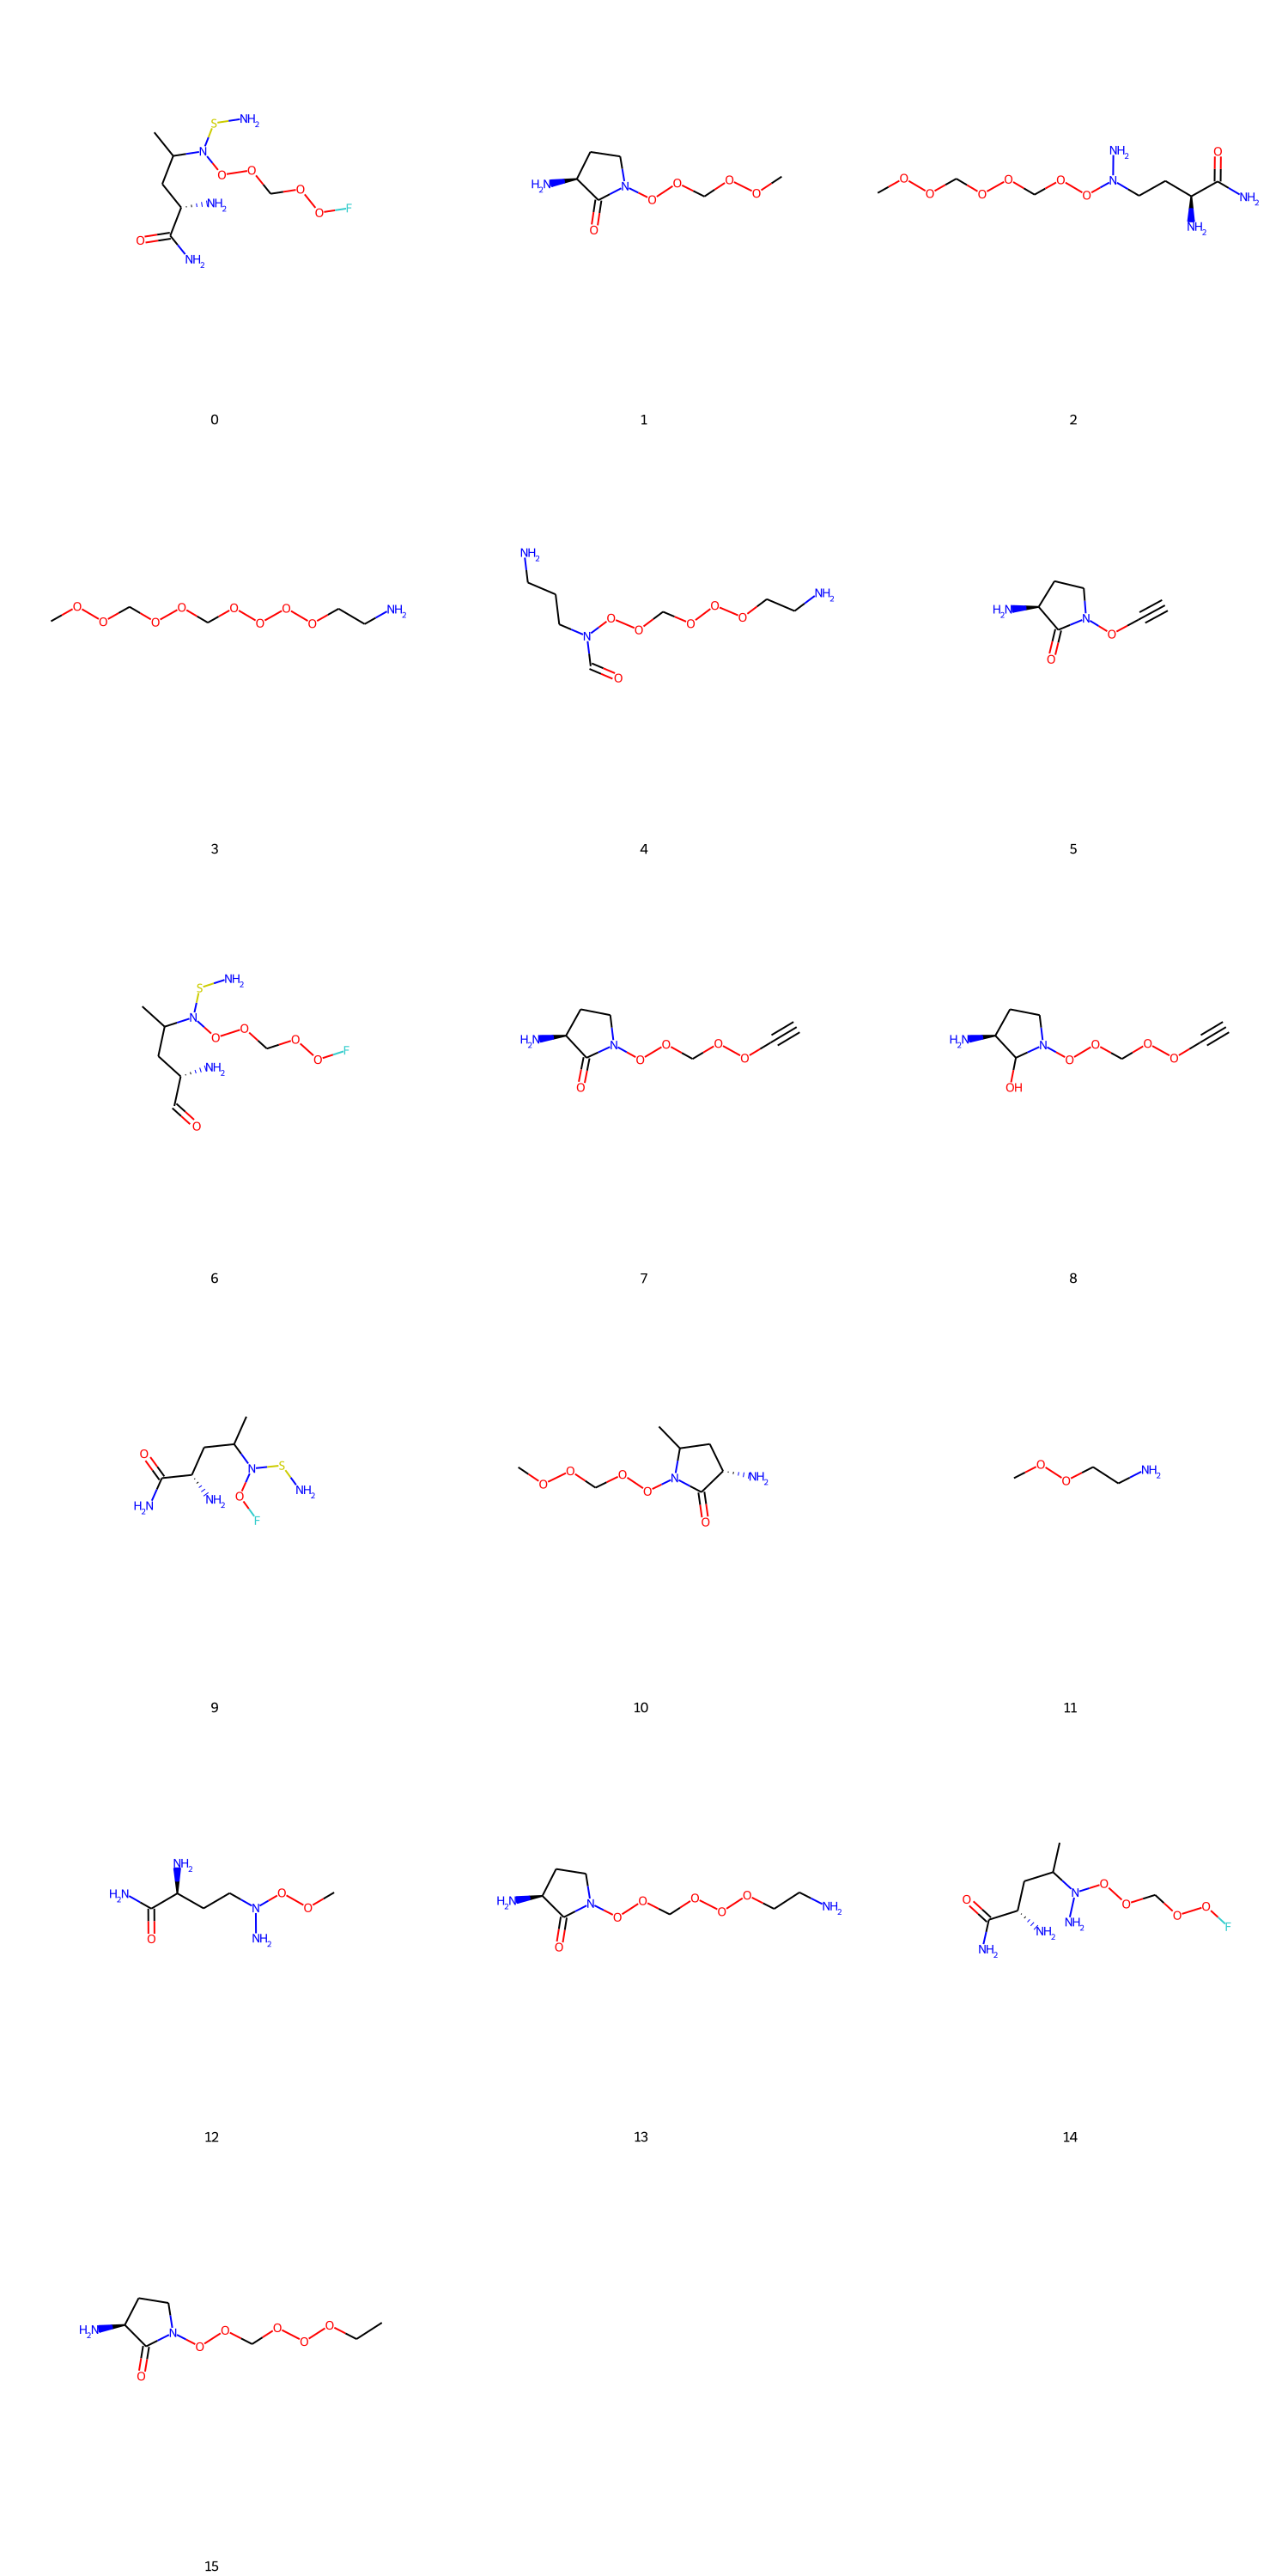

In [47]:
Draw.MolsToGridImage(mols,molsPerRow=3,maxMols=20,legends=[str(x) for x in idx], subImgSize=(500,500))